<a href="https://colab.research.google.com/github/Lustiyana/ML_Capstone-Project/blob/main/Capstone_Project(Klasifikasi_Sampah).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Capstone-Project

/content/drive/MyDrive/Capstone-Project


In [3]:
#Creating Function to Converting size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [4]:
#Creating Function to Getting file size

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras import Model
from keras.models import load_model

Found 8539 files belonging to 9 classes.


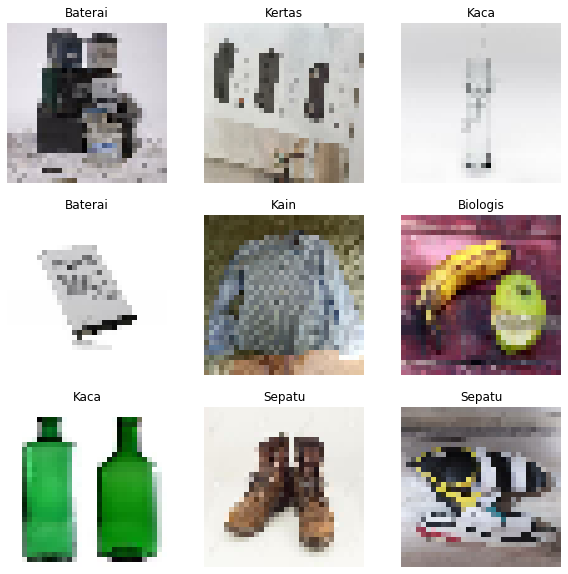

In [6]:
img_height, img_width = 32, 32
batch_size = 20

data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/Capstone-Project/dataset-jenis-sampah/",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
class_name = ['Baterai', 'Biologis', 'Kaca', 'Kain', 'Kardus', 'Kertas', 'Metal', 'Plastik', 'Sepatu']
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [7]:
d = pd.DataFrame()
directory = "/content/drive/MyDrive/Capstone-Project/dataset-jenis-sampah/"

for name in os.listdir(directory):
  temp = pd.DataFrame()
  temp['dir'] = np.nan
  temp['target'] = name
  i = 0
  for image in os.listdir(directory + name):
    temp.loc[i, 'dir'] = directory+name+ "/" + image
    temp.loc[i, 'name'] = name+ "/" + image
    temp.loc[i, 'target'] = name
    i += 1
  d = pd.concat([d, temp], ignore_index=True)
  del temp


train_generator = ImageDataGenerator(
    
    preprocessing_function=preprocess_input,
    validation_split=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True  
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1
)
train_data, val_data = train_test_split(d, test_size=0.1, random_state=42)


train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)


len(train_data), len(val_data), #len(test_data)

(7685, 854)

In [8]:
train_generator = train_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=directory,
    x_col='name',
    y_col='target',
    color_mode="rgb",
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42)

Found 7685 validated image filenames belonging to 9 classes.


In [9]:
val_generator = test_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=directory,
    x_col='name',
    y_col='target',
    color_mode="rgb",
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42)

Found 854 validated image filenames belonging to 9 classes.


In [10]:
base = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3),
)


out = base.output
out = Flatten()(out)
out = Dense(512, activation='relu')(out)
result = Dense(len(class_name),
            activation = 'softmax',
            kernel_initializer = 'random_uniform'
            )(out)
model = Model(
    inputs = base.input,
    outputs = result
)


for layer in base.layers:
    layer.trainable=False

model.compile(
    optimizer= tf.keras.optimizers.SGD(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= ['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [11]:
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights='True', patience=10)


train_samples = train_generator.samples // 128
validation_samples = val_generator.samples // 128
model_info = model.fit(
                      train_generator,
                      steps_per_epoch=train_samples,
                      epochs=30,
                      validation_data=val_generator,
                      callbacks=callback,
                      verbose = 1,
                      validation_steps=validation_samples)

Epoch 1/30
60/60 [==============================] - 272s 4s/step - loss: 1.7329 - accuracy: 0.4732 - val_loss: 1.2613 - val_accuracy: 0.7109
Epoch 2/30
60/60 [==============================] - 271s 5s/step - loss: 1.0604 - accuracy: 0.7576 - val_loss: 0.8825 - val_accuracy: 0.7865
Epoch 3/30
60/60 [==============================] - 251s 4s/step - loss: 0.7576 - accuracy: 0.8212 - val_loss: 0.6271 - val_accuracy: 0.8620
Epoch 4/30
60/60 [==============================] - 246s 4s/step - loss: 0.6431 - accuracy: 0.8336 - val_loss: 0.5486 - val_accuracy: 0.8880
Epoch 5/30
60/60 [==============================] - 250s 4s/step - loss: 0.5442 - accuracy: 0.8578 - val_loss: 0.4838 - val_accuracy: 0.8724
Epoch 6/30
60/60 [==============================] - 261s 4s/step - loss: 0.4904 - accuracy: 0.8721 - val_loss: 0.4662 - val_accuracy: 0.8906
Epoch 7/30
60/60 [==============================] - 245s 4s/step - loss: 0.4487 - accuracy: 0.8805 - val_loss: 0.3891 - val_accuracy: 0.9036
Epoch 8/30
60

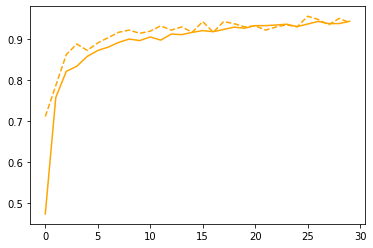

In [12]:
plt.plot(model_info.history['accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(model_info.history['val_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

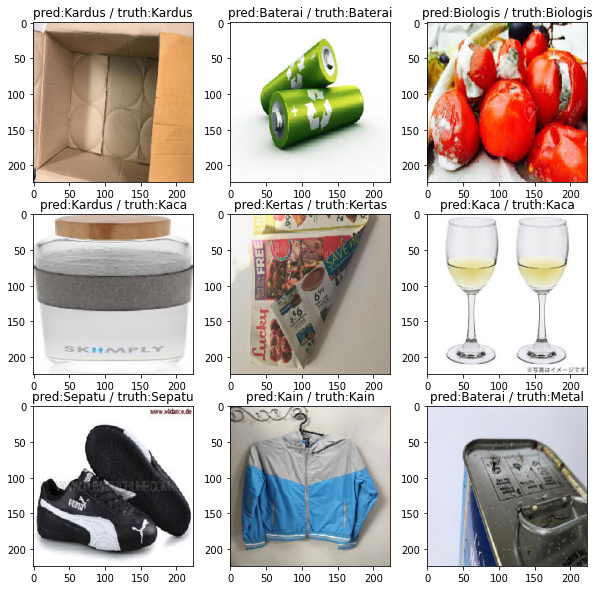

In [13]:
test_x, test_y = val_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_x[i].astype('uint8'))
    plt.title('pred:%s / truth:%s' % (class_name[np.argmax(preds[i])], class_name[np.argmax(test_y[i])]))

In [14]:
#Saving from CNN model

model.save('/content/drive/MyDrive/Capstone-Project/model/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone-Project/model/assets


In [15]:
#Load the Model

model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/Capstone-Project/model/')

In [16]:
#Creating name for the new model

tf_model = "best_tf_lite_model.tflite"

In [17]:
#Convert from existing model into tf.lite


tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpfi6xbz28/assets


In [18]:
#Writing the new tf.lite model


tflite_model_name = tf_model
open(tflite_model_name, "wb").write(tflite_model)

144498404

In [19]:
#Seeing the size of the model

convert_bytes(get_file_size(tf_model), "KB")

File size: 141111.723 Kilobytes


In [20]:
#Getting more infomartion about model

interpreter = tf.lite.Interpreter(model_path = tf_model)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 9]
Output Type: <class 'numpy.float32'>


In [31]:
# !pip install -q tflite-model-maker
# !pip install tflite-support
# !sudo apt -y install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (459 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [33]:
model.export(export_dir='.')

AttributeError: ignored